In [1]:
import argparse
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from utils import DrawLine
import matplotlib.pyplot as plt
import pickle

class Args:
    gamma = 0.99
    action_repeat = 8
    img_stack = 4
    seed = 0
    render = False
    vis = False
    log_interval = 10

args = Args()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(args.seed)
if use_cuda:
    torch.cuda.manual_seed(args.seed)

transition = np.dtype([('s', np.float64, (args.img_stack, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),('r', np.float64), ('s_', np.float64, (args.img_stack, 96, 96))])

In [2]:
class Env:
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, args):
        self.env = gym.make('CarRacing-v3')
        self.reward_threshold = self.env.spec.reward_threshold
        self.args = args

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()
        self.die = False

        obs, _ = self.env.reset()  # Handle tuple return
        img_rgb = obs
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * self.args.img_stack
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for _ in range(self.args.action_repeat):
            img_rgb, reward, terminated, truncated, _ = self.env.step(action)
            die = terminated or truncated

            if die:
                reward += 100
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05

            total_reward += reward
            done = True if self.av_r(reward) <= -0.1 else False

            if done or die:
                break

        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == self.args.img_stack
        return np.array(self.stack), total_reward, done, die

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def rgb2gray(rgb, norm=True):
        if isinstance(rgb, tuple):
            rgb = np.array(rgb, dtype=np.float64)  # Ensure consistent dtype

        if not (rgb.ndim == 3 and rgb.shape[2] == 3):
            raise ValueError("Input must be an RGB image with shape (height, width, 3)")

        gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
        if norm:
            gray = gray / 128. - 1.
        return gray

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [3]:
class Net(nn.Module):
    """
    Actor-Critic Network for PPO
    """

    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(args.img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

In [4]:
class Agent():
    """
    Agent for training
    """
    max_grad_norm = 0.5
    clip_param = 0.1  # epsilon in clipped loss
    ppo_epoch = 10
    buffer_capacity, batch_size = 2000, 128

    def __init__(self):
        self.training_step = 0
        self.net = Net().double().to(device)
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.counter = 0

        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def save_param(self):
        torch.save(self.net.state_dict(), 'param/ppo_net_params1.pkl')

    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True
        else:
            return False
    
    def load_param(self):
        self.net.load_state_dict(torch.load('param/ppo_net_params1.pkl'))

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.buffer['s_'], dtype=torch.double).to(device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        with torch.no_grad():
            target_v = r + args.gamma * self.net(s_)[1]
            adv = target_v - self.net(s)[1]

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

Ep 0	Last score: 99.63	Moving average score: 1.00
Ep 100	Last score: -17.93	Moving average score: 8.15
Ep 200	Last score: -18.01	Moving average score: 7.52
Ep 300	Last score: 124.57	Moving average score: 15.45
Ep 400	Last score: -18.09	Moving average score: 12.47
Ep 500	Last score: 13.42	Moving average score: 13.97
Ep 600	Last score: -17.91	Moving average score: 15.49
Ep 700	Last score: 9.91	Moving average score: 18.25
Ep 800	Last score: 15.98	Moving average score: 20.23
Ep 900	Last score: 14.62	Moving average score: 21.46
Ep 1000	Last score: 56.06	Moving average score: 34.54
Ep 1100	Last score: 18.25	Moving average score: 37.13
Ep 1200	Last score: 171.72	Moving average score: 61.67
Ep 1300	Last score: 56.01	Moving average score: 120.32
Ep 1400	Last score: 320.44	Moving average score: 229.07
Ep 1500	Last score: 315.64	Moving average score: 296.04
Ep 1600	Last score: 434.48	Moving average score: 357.79
Ep 1700	Last score: 422.15	Moving average score: 418.18
Ep 1800	Last score: 602.36	Mo

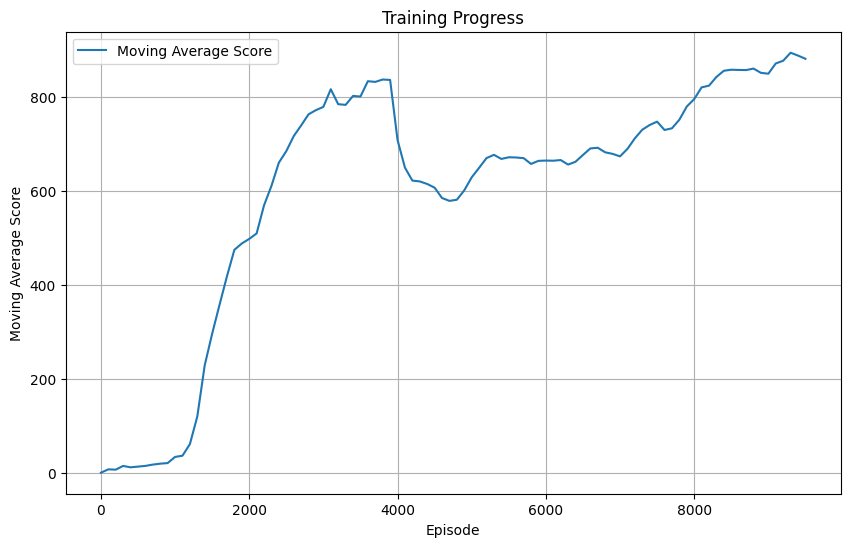

In [5]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    agent = Agent()
    env = Env(args)

    training_records = []
    scores = []
    episodes = []
    running_score = 0

    for i_ep in range(100000):
        score = 0
        state = env.reset()

        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if args.render:
                env.render()
            if agent.store((state, action, a_logp, reward, state_)):
                agent.update()
            score += reward
            state = state_
            if done or die:
                break

        running_score = running_score * 0.99 + score * 0.01

        if i_ep % 100 == 0:
            episodes.append(i_ep)
            scores.append(running_score)
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
        if i_ep % 10 == 0:
            agent.save_param()

        if running_score > env.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {}!".format(running_score, score))
            break

    # Plot scores after training
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, scores, label="Moving Average Score")
    plt.xlabel("Episode")
    plt.ylabel("Moving Average Score")
    plt.title("Training Progress")
    plt.legend()
    plt.grid()
    plt.savefig("training_progress.png")
    plt.show()

In [6]:
print(env.reward_threshold)

900
